In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\risse\Downloads\E2_BigData\dataset\diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Analizamos Missing en la data

In [3]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Analisis Exploratorio

A continuacion visualizaremos los outilers de cada columna a traves de Boxplots

In [4]:
import seaborn as sns

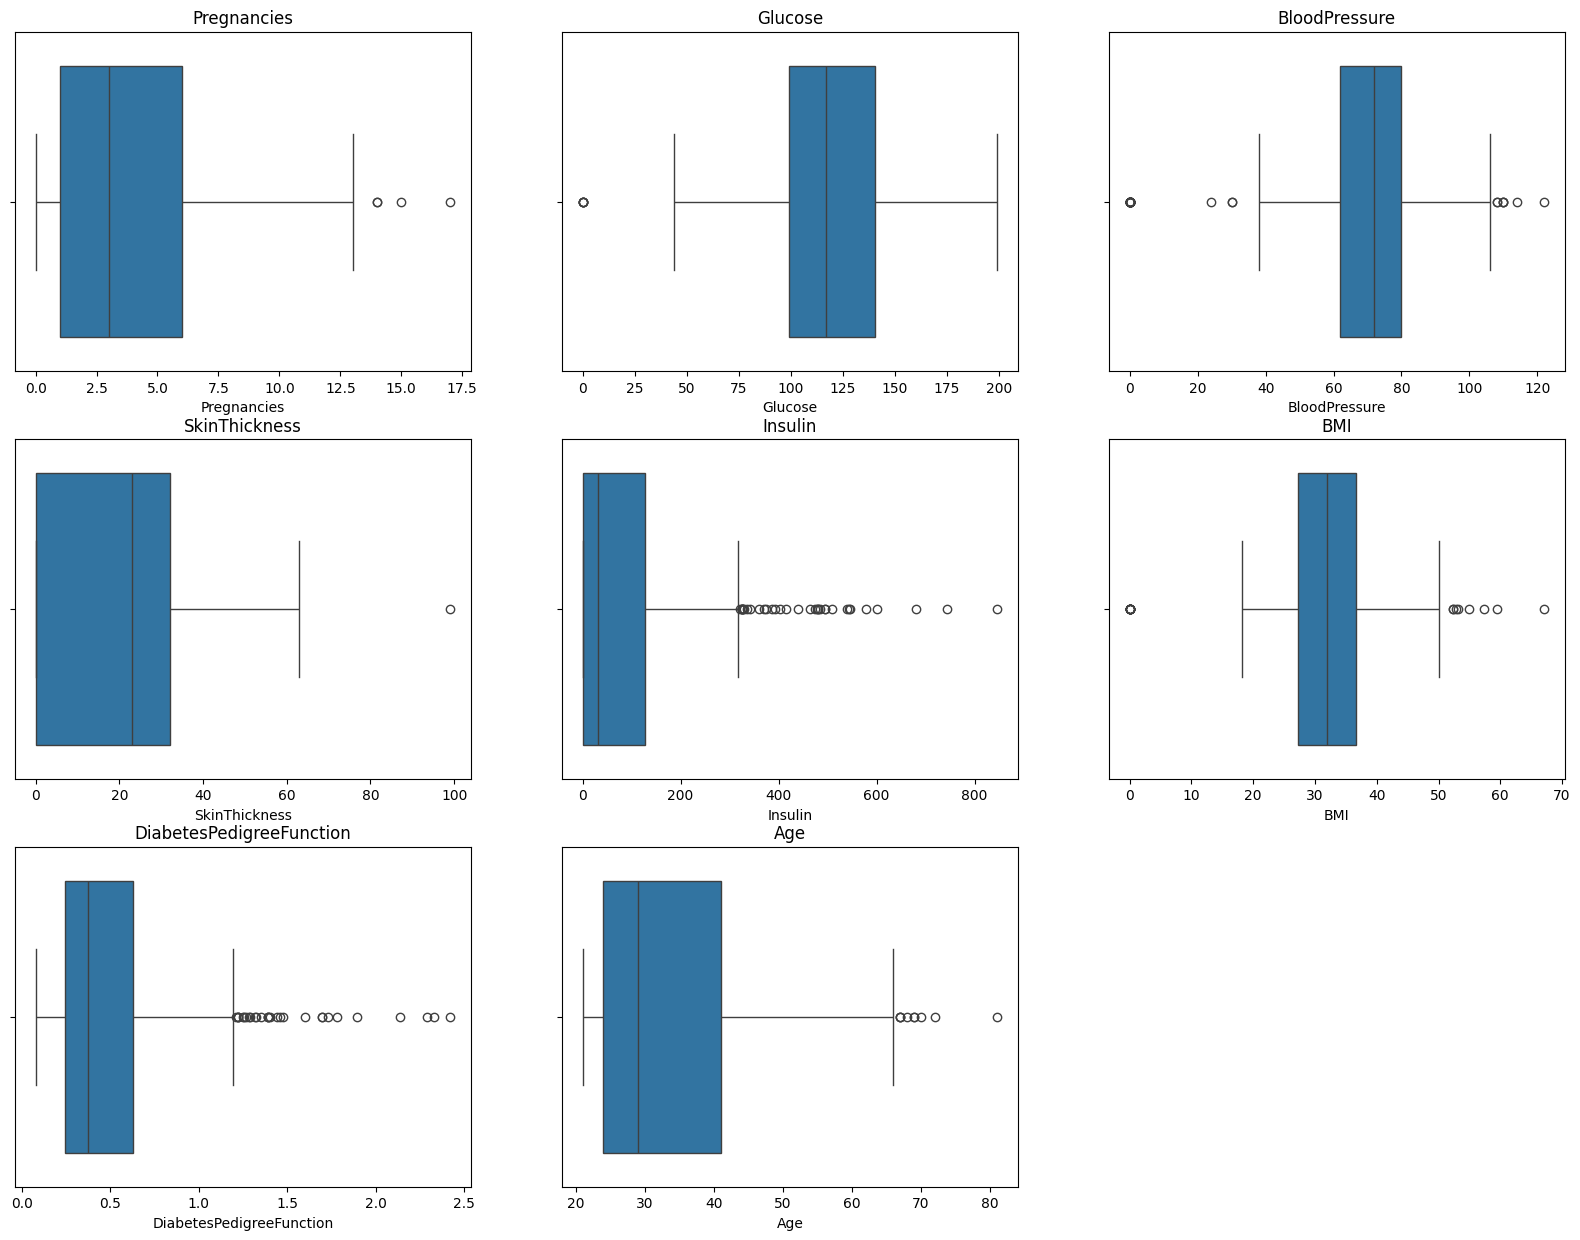

In [5]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.show()

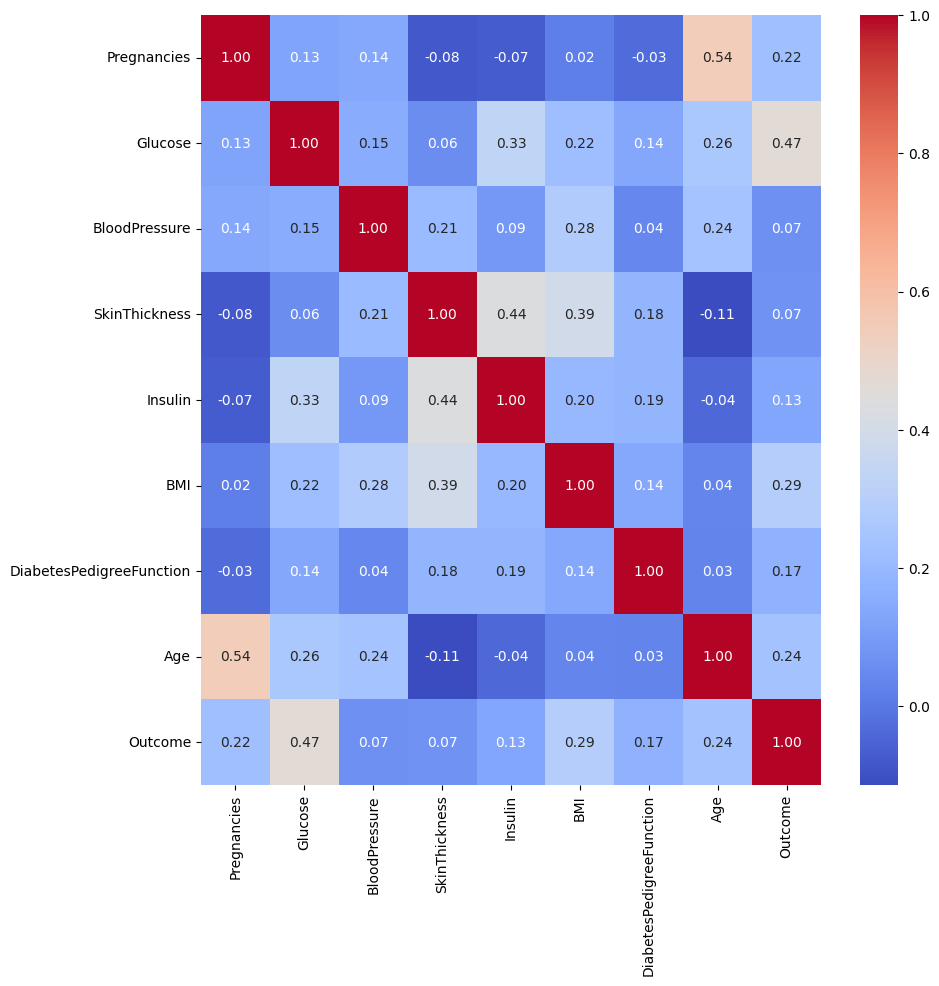

In [6]:
#matriz de correlacion
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [7]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## Aplicacion de ISOLATION FOREST

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [9]:
# Seleccionar solo las columnas numéricas (excluyendo 'Outcome')
df_diabetes = df.drop('Outcome', axis=1)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_diabetes)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Crear una métrica de evaluación personalizada
def custom_scorer(estimator, X):
    scores = estimator.decision_function(X)
    return -np.mean(scores)  # Usamos el promedio de los puntajes de anomalía (negativo porque GridSearchCV maximiza)

# Definir la rejilla de hiperparámetros
param_grid = {'contamination': [0.05, 0.1, 0.15, 0.2]}

# Configurar GridSearchCV con Isolation Forest y el "scoring" personalizado
grid_search = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid,
    cv=5,
    scoring=custom_scorer
)

# Entrenar el modelo
grid_search.fit(X_scaled)

# Mejor valor de contaminación
best_contamination = grid_search.best_params_['contamination']
print("Mejor valor de contaminación:", best_contamination)


Mejor valor de contaminación: 0.2


In [12]:
# Inicializar el modelo Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=best_contamination, random_state=42)

# Ajustar el modelo a los datos
outliers = iso_forest.fit_predict(X_scaled)

# Convertir el resultado a formato legible: -1 = outlier, 1 = normal
df['outlier'] = outliers


In [13]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,outlier
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,1
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,1
4,0,137,40,35,168,43.1,2.288,33,1,-1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,-1
764,2,122,70,27,0,36.8,0.340,27,0,1
765,5,121,72,23,112,26.2,0.245,30,0,1
766,1,126,60,0,0,30.1,0.349,47,1,1


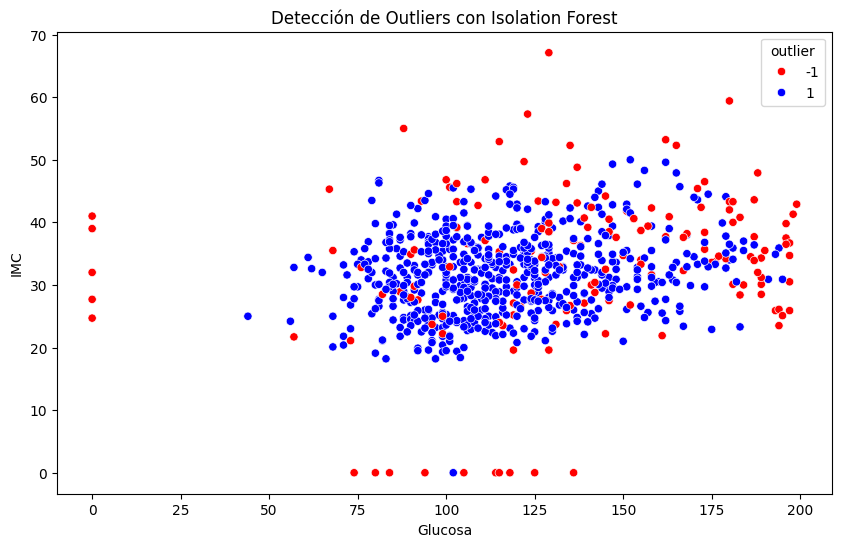

In [14]:
# Visualización de los outliers detectados
plt.figure(figsize=(10, 6))

# Graficar con hue=outlier para identificar los outliers visualmente
sns.scatterplot(x=df['Glucose'], y=df['BMI'], hue=df['outlier'], palette={1: 'blue', -1: 'red'})
plt.title('Detección de Outliers con Isolation Forest')
plt.xlabel('Glucosa')
plt.ylabel('IMC')
plt.show()

In [15]:
# Analizar la relación entre outliers y 'Resultado'
outliers_vs_resultado = df.groupby(['outlier', 'Outcome']).size().unstack()

# Visualizar la tabla
outliers_vs_resultado

Outcome,0,1
outlier,,
-1,68,86
1,432,182


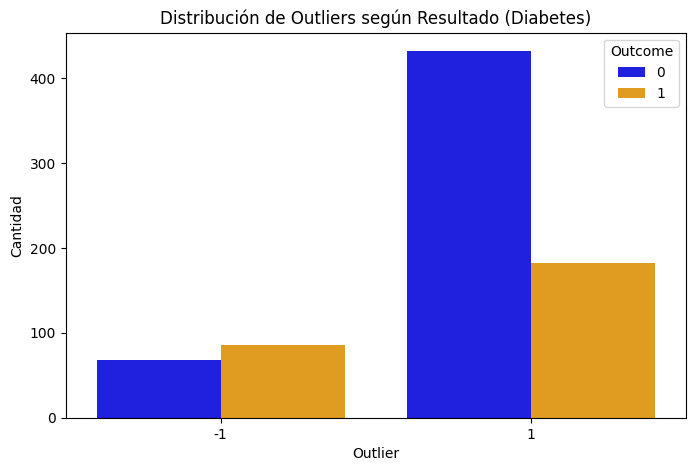

In [17]:
# Visualización de la distribución de outliers según el resultado
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='outlier', hue='Outcome', palette={0: 'blue', 1: 'orange'})
plt.title('Distribución de Outliers según Resultado (Diabetes)')
plt.xlabel('Outlier')
plt.ylabel('Cantidad')
plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# Convertir etiquetas del Isolation Forest (-1, 1) a (1 = outlier, 0 = normal)
df['predicted_outlier'] = df['outlier'].apply(lambda x: 1 if x == -1 else 0)

# Evaluar desempeño comparando con Outcome
print("Matriz de Confusión:")
print(confusion_matrix(df['Outcome'], df['predicted_outlier']))

print("\nReporte de Clasificación:")
print(classification_report(df['Outcome'], df['predicted_outlier']))


Matriz de Confusión:
[[432  68]
 [182  86]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.70      0.86      0.78       500
           1       0.56      0.32      0.41       268

    accuracy                           0.67       768
   macro avg       0.63      0.59      0.59       768
weighted avg       0.65      0.67      0.65       768



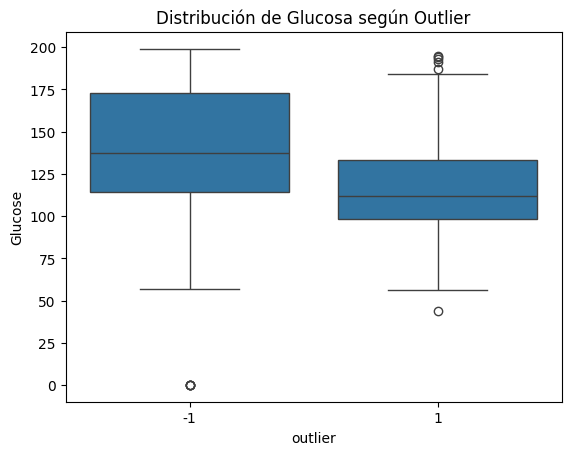

In [19]:
# Comparar distribuciones de Glucose entre outliers y normales
sns.boxplot(x='outlier', y='Glucose', data=df)
plt.title('Distribución de Glucosa según Outlier')
plt.show()


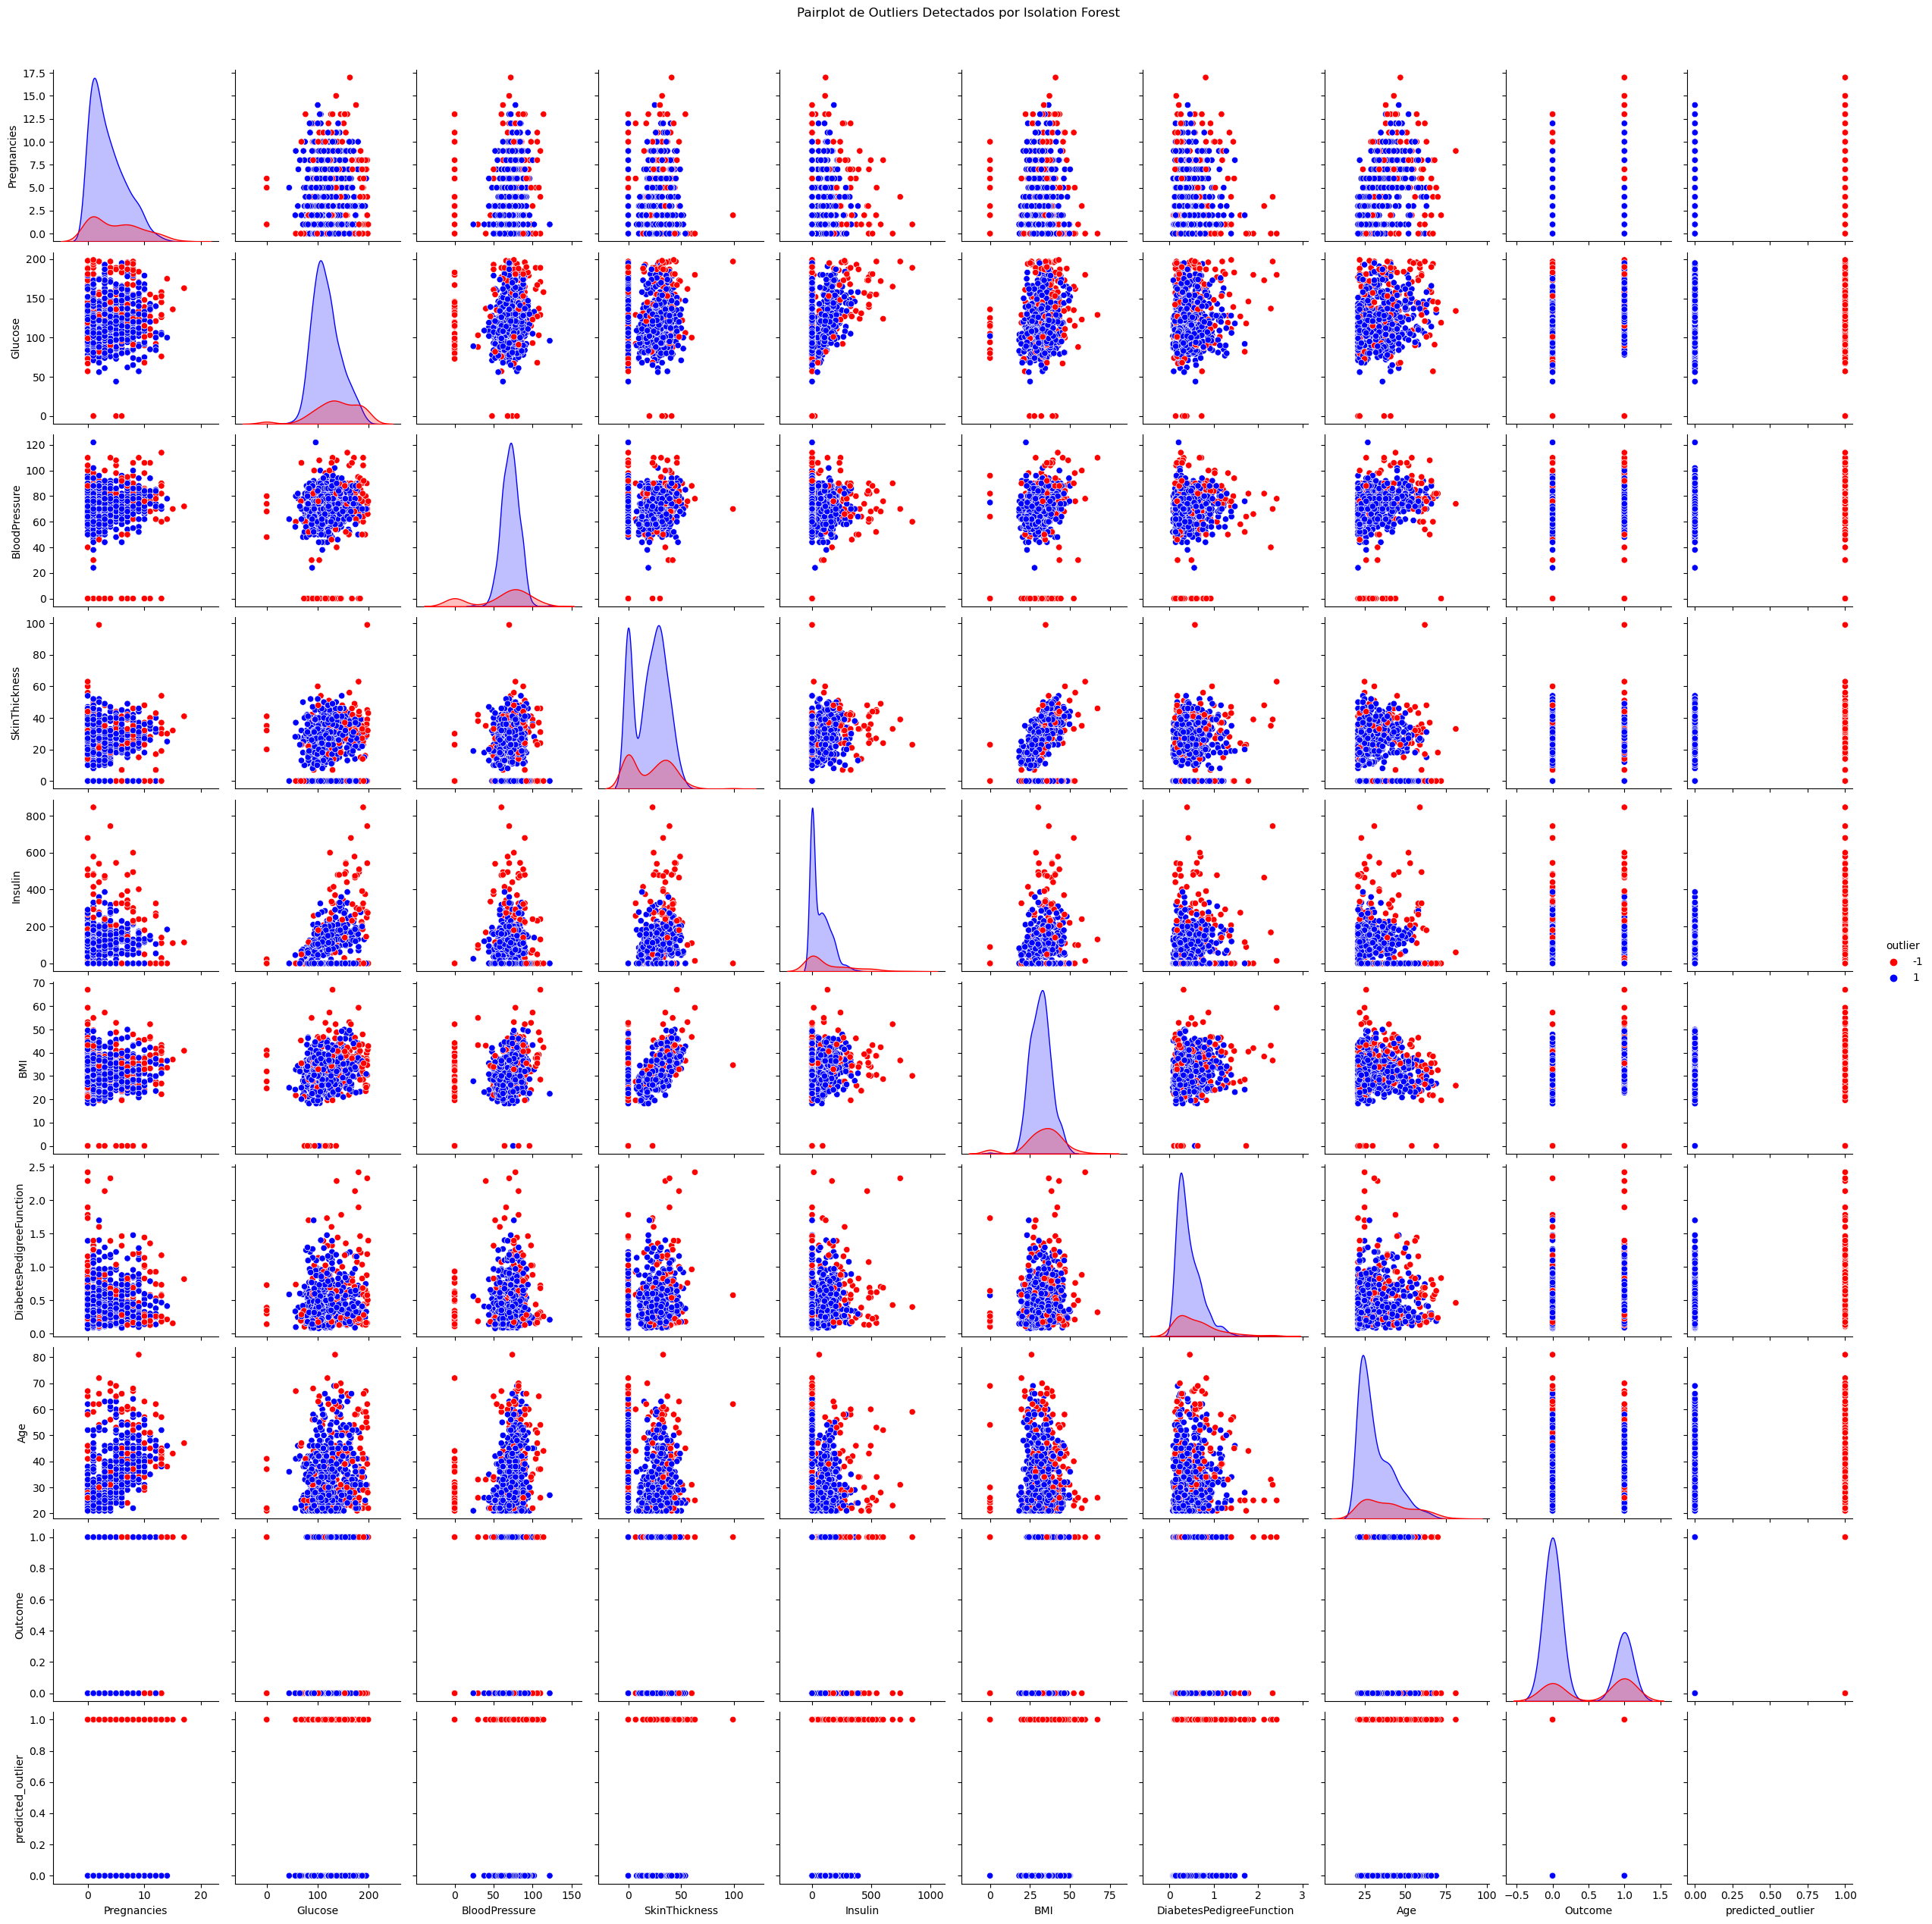

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un pairplot para ver múltiples combinaciones de variables
sns.pairplot(df, hue='outlier', palette={1: "blue", -1: "red"})
plt.suptitle("Pairplot de Outliers Detectados por Isolation Forest", y=1.02)
plt.show()
